# 11 - Profit of future trends with multiple Model (Smaller window size)

Try with a smaller window size and see how it affects the results.

dataSize: 1010
windowSize: 21
testSize: 303
input_scale: 676.967
output_scale: 5.841402995389024


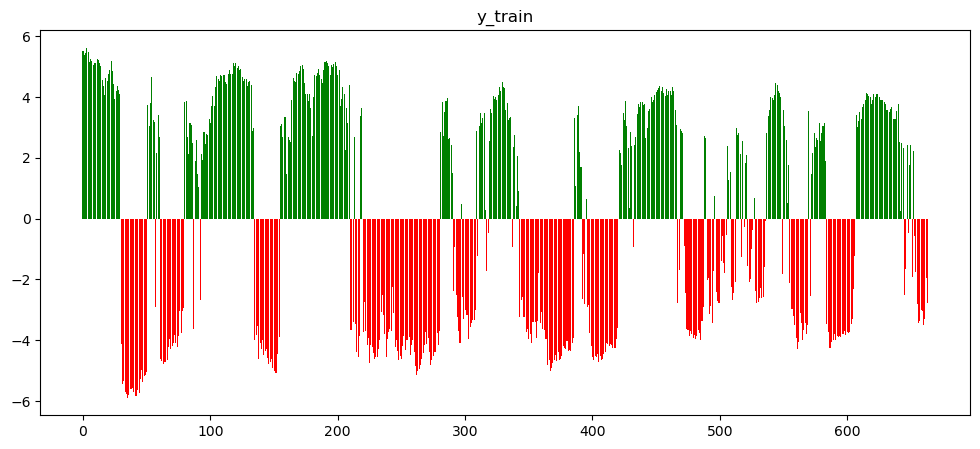

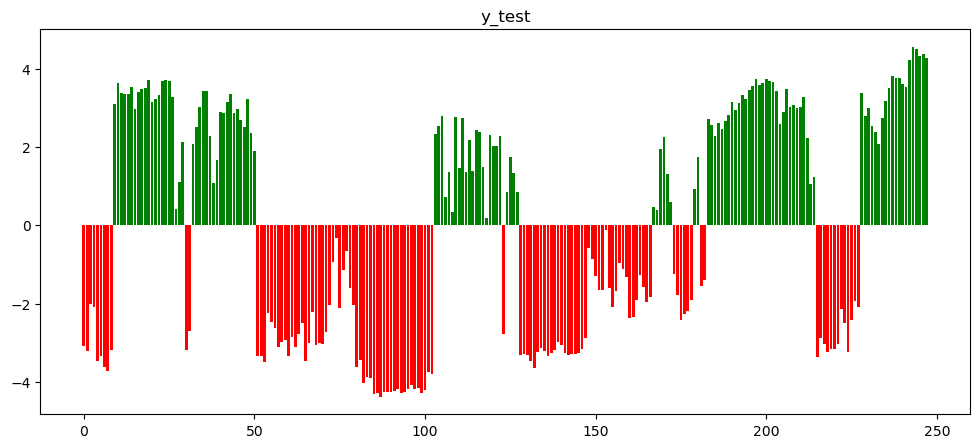

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from util import *
from nbeat import *

bnb_data = pd.read_csv('data/BNBUSDT_1D_2.csv')
bnb_close_values = bnb_data['Close']
future_period = 21
profit_of_future_log = covertToLogScale(computeProfitOfFuture(bnb_close_values, future_period))
skip_count = 390

input_data = np.array(bnb_data['Close'][skip_count:-future_period])
output_data = profit_of_future_log[skip_count:]

dataSize = len(input_data)
assert(dataSize == len(output_data))
windowSize = future_period
testSize = round(dataSize * 0.3)
print(f"dataSize: {dataSize}")
print(f"windowSize: {windowSize}")
print(f"testSize: {testSize}")

input_scale = np.max(input_data)
output_scale = np.max(profit_of_future_log)
print(f"input_scale: {input_scale}")
print(f"output_scale: {output_scale}")

x_train = prepareTrainingInputs(input_data, windowSize, testSize)
y_train = prepareTraingingOutputs(output_data, windowSize, testSize)
x_test = prepareTestingInputs(input_data, windowSize, testSize)
y_test = prepareTestingOutputs(output_data, testSize)

x_train_rs, y_train_rs = undersampleSeriesDataTomekBySign(x_train, y_train)
x_test_rs, y_test_rs = undersampleSeriesDataTomekBySign(x_test, y_test)

# try skipping scaling this time
# y_train_scaled = rescalingBySign(y_train_rs)
# y_test_scaled = rescalingBySign(y_test_rs)

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_train_rs)
plt.title('y_train')
plt.show()

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_test_rs)
plt.title('y_test')
plt.show()


In [2]:
# refer to 09-pof-singlemodel.ipynb
ut_target = 2.5
dt_target = -2.5
nt_target = 2.9
scaling = 3 / 2.5

up_trend_train, down_trend_train, neutral_trend_train = computeUDNTrend(y_train_rs, ut_target, dt_target, nt_target, scaling)
up_trend_test, down_trend_test, neutral_trend_test = computeUDNTrend(y_test_rs, ut_target, dt_target, nt_target, scaling)

print(f"train up trend mean: {np.mean(up_trend_train)}")
print(f"train down trend mean: {np.mean(down_trend_train)}")
print(f"train neutral trend mean: {np.mean(neutral_trend_train)}")
print(f"test up trend mean: {np.mean(up_trend_test)}")
print(f"test down trend mean: {np.mean(down_trend_test)}")
print(f"test neutral trend mean: {np.mean(neutral_trend_test)}")

train up trend mean: 0.45745264732539165
train down trend mean: 0.45318482903933244
train neutral trend mean: 0.3980493940450537
test up trend mean: 0.3869182129648781
test down trend mean: 0.3863440515688829
test neutral trend mean: 0.7211234331893736


Trivial prediction brenchmarking

In [3]:
test_count = len(up_trend_test)
trivial_prediction = np.full([test_count], np.tanh(3))
up_rmse0 = tf.keras.metrics.RootMeanSquaredError()(trivial_prediction, up_trend_test).numpy()
down_rmse0 = tf.keras.metrics.RootMeanSquaredError()(trivial_prediction, down_trend_test).numpy()
trivial_prediction = np.ones(test_count)
neutral_rmse0 = tf.keras.metrics.RootMeanSquaredError()(trivial_prediction, neutral_trend_test).numpy()
print(f"RMSE up: {up_rmse0:.2f}, down: {down_rmse0:.2f}, neutral: {neutral_rmse0:.2f}")

RMSE up: 0.76, down: 0.76, neutral: 0.43


In [4]:
datasets = [
  { 'y_train': up_trend_train, 'y_test': up_trend_test, 'x_train': x_train_rs, 'x_test': x_test_rs, 'name': "Up trend" },
  { 'y_train': down_trend_train, 'y_test': down_trend_test, 'x_train': x_train_rs, 'x_test': x_test_rs, 'name': "Down trend" },
  { 'y_train': neutral_trend_train, 'y_test': neutral_trend_test, 'x_train': x_train_rs, 'x_test': x_test_rs, 'name': "Neutral trend" },
]

for dataset in datasets:
  dataset['train_dataset'], dataset['test_dataset'] = prepareDataSetFromArray(dataset['x_train'], dataset['y_train'], dataset['x_test'], dataset['y_test'], shuffle=True, batch_size=256)


#### [Model1] ARIMA

In [ ]:
from operator import itemgetter

neuronCount = 128

for dataset in datasets:
  name, x_test, y_test, train_dataset, test_dataset = itemgetter('name', 'x_test', 'y_test', 'train_dataset', 'test_dataset')(dataset)
  print(f"================= {name} training ================")
  # Create input to stacks
  input = layers.Input(shape=(windowSize,1), name="stack_input")
  x = input
  x = tf.keras.layers.multiply([x, np.array([1./input_scale])])
  x = tf.keras.layers.LSTM(neuronCount, activation='relu', return_sequences=True)(x)
  x = tf.keras.layers.LSTM(round(neuronCount/2), activation='relu', return_sequences=True)(x)
  # residual
  residual = tf.keras.layers.LSTM(round(neuronCount/2), return_sequences=True)(input)  # Skip connection
  x = tf.keras.layers.Add()([x, residual])  # Adding the residual connection
  x = tf.keras.layers.LSTM(round(neuronCount/4), activation='relu')(x)
  # dense layers
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(32, activation='relu')(x)
  x = tf.keras.layers.Dense(1, activation="linear")(x)
  model = tf.keras.Model(inputs=input, outputs=x)
  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(0.0005),
                metrics=["mse"])
  dataset['model1'] = model
  # train for 5 epochs first
  # noValidationTrainingAndReport(model, x_test, y_test, train_dataset, epochs=7, plotGraph=False)
  history, rmse, corr = standardTrainingAndReport(model, x_test, y_test, train_dataset, test_dataset)
  dataset['history1'] = history
  dataset['rmse1'] = rmse
  dataset['corr1'] = corr

================= Up trend training ================

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.

Epoch 13: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.

Epoch 18: ReduceLROnPlateau reducing learning rate to 5.000000328436726e-07.
Restoring model weights from the end of the best epoch: 3.

Epoch 23: ReduceLROnPlateau reducing learning rate to 5.000000555810402e-08.
Epoch 23: early stopping
8/8 [==============================] - 1s 28ms/step - loss: 0.2142 - mse: 0.2142
loss: 0.4628317751273846
corr: 0.16572247378239566
================= Down trend training ================

Epoch 13: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.

Epoch 18: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.

Epoch 23: ReduceLROnPlateau reducing learning rate to 5.000000328436726e-07.
Restoring model weights from the end of the best epoch: 8.

Epoch 28: ReduceLROnPlateau reducing learning rate to 5.0000005558104

##### Training predictions

In [ ]:
prediction = np.column_stack([dataset['model1'].predict(dataset['x_train']) for dataset in datasets])

# clip prediction before plotting
dataCount = len(prediction)
prediction = np.clip(prediction, np.zeros([dataCount, 3]), np.ones([dataCount, 3]))

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, up_trend_train, down_trend_train, neutral_trend_train, ut_target)
ax.plot(y_train_rs, label='actual')
ax.set_title('Trends vs actual PoF')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target)
ax.plot(y_train_rs, label='actual')
ax.set_title('Training prediction')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=Normalize(vmin=np.min(prediction), vmax=np.max(prediction)))
ax.plot(y_train_rs, label='actual')
ax.set_title('Training prediction (fix norm)')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=None)
ax.plot(y_train_rs, label='actual')
ax.set_title('Training prediction (no norm)')


##### Testing predictions

In [ ]:
prediction = np.column_stack([dataset['model1'].predict(dataset['x_test']) for dataset in datasets])

# clip prediction before plotting
dataCount = len(prediction)
prediction = np.clip(prediction, np.zeros([dataCount, 3]), np.ones([dataCount, 3]))

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, up_trend_test, down_trend_test, neutral_trend_test, ut_target)
ax.plot(y_test_rs, label='actual')
ax.set_title('Trends vs actual PoF')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target)
ax.plot(y_test_rs, label='actual')
ax.set_title('Testing prediction')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=Normalize(vmin=np.min(prediction), vmax=np.max(prediction)))
ax.plot(y_test_rs, label='actual')
ax.set_title('Testing prediction (fix norm)')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=None)
ax.plot(y_test_rs, label='actual')
ax.set_title('Testing prediction (no norm)')

#### [Model2] N-BEATS

In [ ]:
for dataset in datasets:
  name, x_test, y_test, train_dataset, test_dataset = itemgetter('name', 'x_test', 'y_test', 'train_dataset', 'test_dataset')(dataset)
  print(f"================= {name} training ================")
  nbeatNeuronCount = 512
  nBeatLayerCount = 4
  nBeatStackCount = 30
  input = layers.Input(shape=(windowSize), name="stack_input")
  x = input
  x = tf.keras.layers.multiply([x, np.array([1./input_scale])])
  x = buildNBeatLayers(windowSize, windowSize+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)
  model = tf.keras.Model(inputs=input, outputs=x)
  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(0.00025),
                metrics=["mse"])
  dataset['model2'] = model
  # train for 3 epoches first
  # noValidationTrainingAndReport(model, x_test, y_test, train_dataset, epochs=3, plotGraph=False)
  history, rmse, corr = standardTrainingAndReport(model, x_test, y_test, train_dataset, test_dataset)
  dataset['history2'] = history
  dataset['rmse2'] = rmse
  dataset['corr2'] = corr

##### Training predictions

In [ ]:
prediction = np.column_stack([dataset['model2'].predict(dataset['x_train']) for dataset in datasets])

# clip prediction before plotting
dataCount = len(prediction)
prediction = np.clip(prediction, np.zeros([dataCount, 3]), np.ones([dataCount, 3]))

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, up_trend_train, down_trend_train, neutral_trend_train, ut_target)
ax.plot(y_train_rs, label='actual')
ax.set_title('Trends vs actual PoF')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target)
ax.plot(y_train_rs, label='actual')
ax.set_title('Training prediction')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=Normalize(vmin=np.min(prediction), vmax=np.max(prediction)))
ax.plot(y_train_rs, label='actual')
ax.set_title('Training prediction (fix norm)')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=None)
ax.plot(y_train_rs, label='actual')
ax.set_title('Training prediction (no norm)')


##### Testing predictions

In [ ]:
prediction = np.column_stack([dataset['model2'].predict(dataset['x_test']) for dataset in datasets])

# clip prediction before plotting
dataCount = len(prediction)
prediction = np.clip(prediction, np.zeros([dataCount, 3]), np.ones([dataCount, 3]))

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, up_trend_test, down_trend_test, neutral_trend_test, ut_target)
ax.plot(y_test_rs, label='actual')
ax.set_title('Trends vs actual PoF')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target)
ax.plot(y_test_rs, label='actual')
ax.set_title('Testing prediction')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=Normalize(vmin=np.min(prediction), vmax=np.max(prediction)))
ax.plot(y_test_rs, label='actual')
ax.set_title('Testing prediction (fix norm)')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=None)
ax.plot(y_test_rs, label='actual')
ax.set_title('Testing prediction (no norm)')

In [ ]:
species = ("Trivial", "ARIMA", "N-Beats")
rmses = {
    'Up': { 'measurement': [up_rmse0, datasets[0]['rmse1'], datasets[0]['rmse2']], 'color': 'green' },
    'Down': { 'measurement': [down_rmse0, datasets[1]['rmse1'], datasets[1]['rmse2']], 'color': 'red' },
    'Neutral': { 'measurement': [neutral_rmse0, datasets[2]['rmse1'], datasets[2]['rmse2']], 'color': 'yellow' },
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(9, 5))

for attribute, info in rmses.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, info['measurement'], width, label=attribute, color=info['color'])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Root Mean Squared Error')
ax.set_xticks(x + width, species)
ax.set_ylim(0, 0.9)
ax.legend(loc='upper left', ncols=3)
plt.show()


In [ ]:
species = ("ARIMA", "N-Beats")
rmses = {
    'Up': { 'measurement': [datasets[0]['corr1'], datasets[0]['corr2']], 'color': 'green' },
    'Down': { 'measurement': [datasets[1]['corr1'], datasets[1]['corr2']], 'color': 'red' },
    'Neutral': { 'measurement': [datasets[2]['corr1'], datasets[2]['corr2']], 'color': 'yellow' }
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, info in rmses.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, info['measurement'], width, color=info['color'])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Correlations')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
plt.show()


Overall no significant change at all